
# Ford Focus Fiyat Tahmin Modeli (XGBoost)

Bu projede, ikinci el **Ford Focus** araçlarının özelliklerine göre tahmini fiyatlarını belirlemek için bir makine öğrenimi modeli oluşturulmuştur.  
Kullanılan algoritma: **XGBoost Regressor**

**Aşamalar:**
1. Kütüphaneler
2. Keşifsel Veri Analizi (EDA)
3. Veri Ön İşleme
4. Model Eğitimi
5. Değerlendirme ve Tahmin Karşılaştırması


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
df = pd.read_csv('data/focus.csv')

In [3]:
df.head()

,model,year,price,transmission,mileage,fuelType,engineSize
0,Focus,2016,8000,Manual,38852,Petrol,1.0
1,Focus,2019,13400,Manual,11952,Petrol,1.0
2,Focus,2019,14600,Manual,22142,Petrol,1.5
3,Focus,2016,9450,Manual,14549,Diesel,1.6
4,Focus,2015,9999,Manual,7010,Diesel,1.6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         5454 non-null   object 
 1   year          5454 non-null   int64  
 2   price         5454 non-null   int64  
 3   transmission  5454 non-null   object 
 4   mileage       5454 non-null   int64  
 5   fuelType      5454 non-null   object 
 6   engineSize    5454 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 298.4+ KB


In [5]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
engineSize      0
dtype: int64

In [6]:
df.describe()

,year,price,mileage,engineSize
count,5454.000000,5454.000000,5454.000000,5454.000000
mean,2017.113495,13581.958379,22876.582692,1.363256
std,2.170301,4737.282779,20596.754387,0.400233
min,2002.000000,495.000000,1.000000,0.000000
25%,2016.000000,10489.250000,9137.000000,1.000000
50%,2017.000000,13299.500000,15944.500000,1.500000
75%,2019.000000,16987.250000,30000.000000,1.600000
max,2020.000000,54995.000000,177644.000000,2.500000


In [7]:
sns.set(style="whitegrid")

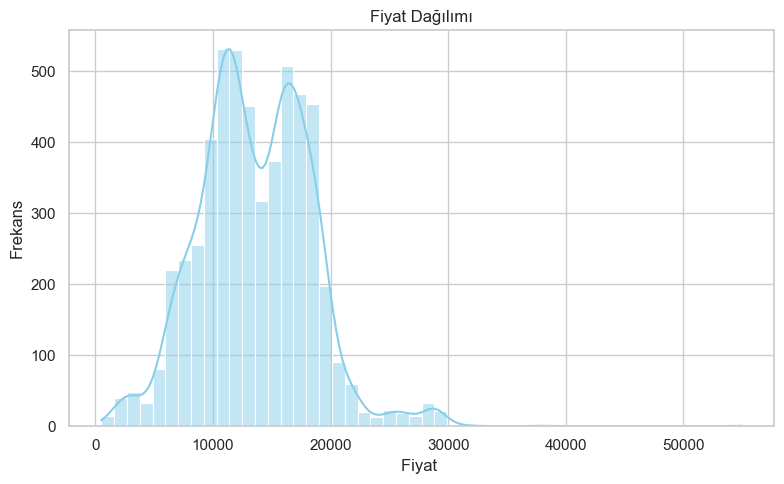

In [8]:
# Fiyat dağılımı
plt.figure(figsize=(8, 5))
sns.histplot(df["price"], bins=50, kde=True, color="skyblue")
plt.title("Fiyat Dağılımı")
plt.xlabel("Fiyat ")
plt.ylabel("Frekans")
plt.tight_layout()
plt.show()

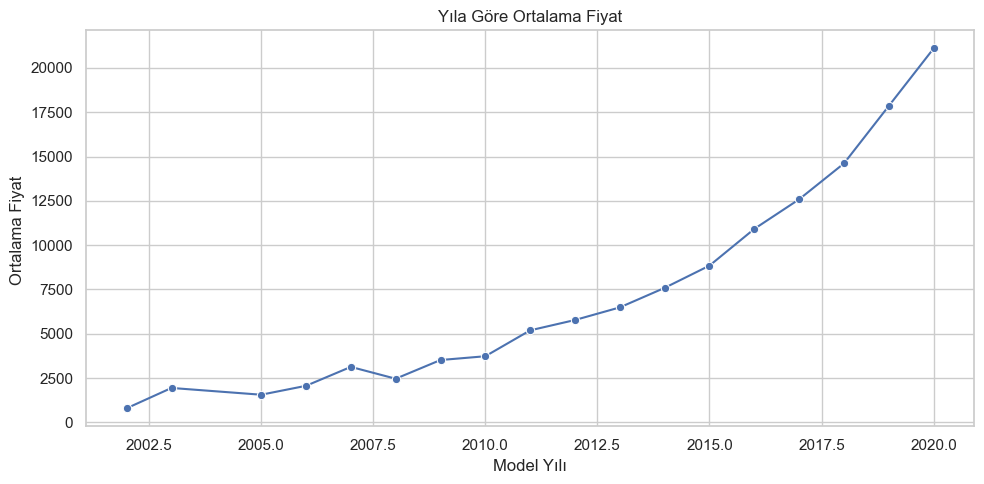

In [9]:
# Yıla göre ortalama fiyat
plt.figure(figsize=(10, 5))
yearly_price = df.groupby("year")["price"].mean().reset_index()
sns.lineplot(x="year", y="price", data=yearly_price, marker="o")
plt.title("Yıla Göre Ortalama Fiyat")
plt.ylabel("Ortalama Fiyat ")
plt.xlabel("Model Yılı")
plt.tight_layout()
plt.show()

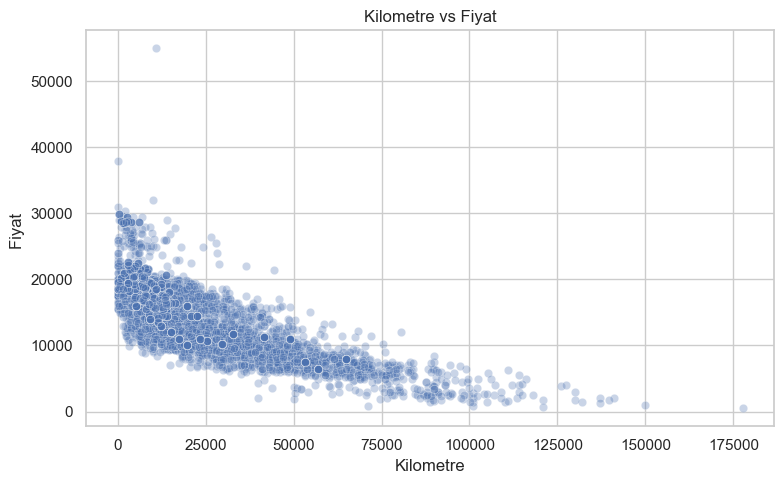

In [10]:
# Mileage vs Price (scatter)
plt.figure(figsize=(8, 5))
sns.scatterplot(x="mileage", y="price", data=df, alpha=0.3)
plt.title("Kilometre vs Fiyat")
plt.xlabel("Kilometre")
plt.ylabel("Fiyat ")
plt.tight_layout()
plt.show()

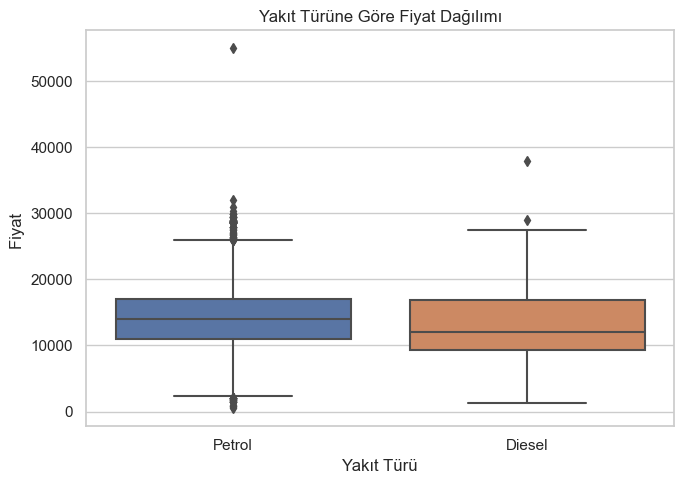

In [11]:
# Yakıt tipine göre fiyat

plt.figure(figsize=(7, 5))
sns.boxplot(x="fuelType", y="price", data=df)
plt.title("Yakıt Türüne Göre Fiyat Dağılımı")
plt.xlabel("Yakıt Türü")
plt.ylabel("Fiyat ")
plt.tight_layout()
plt.show()

In [12]:
df["model"].nunique()

1

In [13]:
df.drop('model',axis=1, inplace=True)

In [14]:
df

,year,price,transmission,mileage,fuelType,engineSize
0,2016,8000,Manual,38852,Petrol,1.0
1,2019,13400,Manual,11952,Petrol,1.0
2,2019,14600,Manual,22142,Petrol,1.5
3,2016,9450,Manual,14549,Diesel,1.6
4,2015,9999,Manual,7010,Diesel,1.6
...,...,...,...,...,...,...
5449,2019,18745,Manual,7855,Diesel,2.0
5450,2019,16350,Manual,13891,Petrol,1.0
5451,2019,16850,Manual,13452,Petrol,1.0
5452,2019,17310,Automatic,13376,Petrol,1.0


In [15]:
# Kategorik sütunları One-Hot Encoding 
df_encoded = pd.get_dummies(df[["transmission", "fuelType"]], drop_first=True)

# Sayısal sütunlar
num_cols = ["year", "mileage", "engineSize"]

# Özellikleri birleştir
X = pd.concat([df[num_cols].reset_index(drop=True),
               df_encoded.reset_index(drop=True)], axis=1).values

# Hedef değişken 
y = df["price"].values

In [16]:
df_encoded.head()

,transmission_Manual,transmission_Semi-Auto,fuelType_Petrol
0,True,False,True
1,True,False,True
2,True,False,True
3,True,False,False
4,True,False,False


In [17]:
df

,year,price,transmission,mileage,fuelType,engineSize
0,2016,8000,Manual,38852,Petrol,1.0
1,2019,13400,Manual,11952,Petrol,1.0
2,2019,14600,Manual,22142,Petrol,1.5
3,2016,9450,Manual,14549,Diesel,1.6
4,2015,9999,Manual,7010,Diesel,1.6
...,...,...,...,...,...,...
5449,2019,18745,Manual,7855,Diesel,2.0
5450,2019,16350,Manual,13891,Petrol,1.0
5451,2019,16850,Manual,13452,Petrol,1.0
5452,2019,17310,Automatic,13376,Petrol,1.0


In [18]:
X 

array([[2016, 38852, 1.0, True, False, True],
       [2019, 11952, 1.0, True, False, True],
       [2019, 22142, 1.5, True, False, True],
       ...,
       [2019, 13452, 1.0, True, False, True],
       [2019, 13376, 1.0, False, False, True],
       [2019, 7886, 1.0, False, False, True]], dtype=object)

In [19]:
y

array([ 8000, 13400, 14600, ..., 16850, 17310, 17610], dtype=int64)

In [20]:
# Veriyi %80 eğitim, %20 test olacak şekilde ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Modeli oluştur
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Eğit
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
# Tahmin yap
y_pred = xgb_model.predict(X_test)

# MSE ve RMSE 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


RMSE: 1288.56
R^2 Score: 0.93


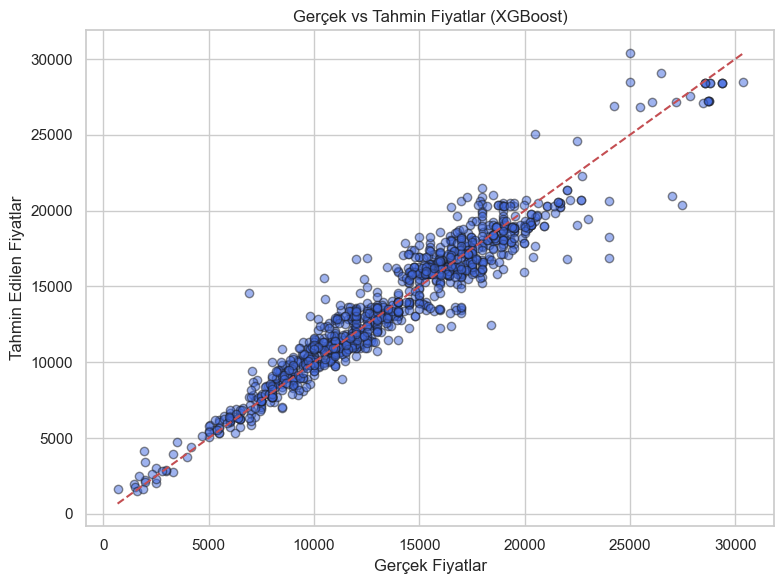

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Gerçek Fiyatlar")
plt.ylabel("Tahmin Edilen Fiyatlar")
plt.title("Gerçek vs Tahmin Fiyatlar (XGBoost)")
plt.tight_layout()
plt.show()


In [24]:
for gerçek, tahmin in zip(y_test[:10], y_pred[:10]):
    print(f"Gerçek Değer: {gerçek:.0f}  — Tahmin: {tahmin:.0f} ")

Gerçek Değer: 16395  — Tahmin: 16511 
Gerçek Değer: 11799  — Tahmin: 12820 
Gerçek Değer: 10000  — Tahmin: 10040 
Gerçek Değer: 8700  — Tahmin: 9412 
Gerçek Değer: 24250  — Tahmin: 26882 
Gerçek Değer: 17500  — Tahmin: 18058 
Gerçek Değer: 17999  — Tahmin: 18874 
Gerçek Değer: 18890  — Tahmin: 18559 
Gerçek Değer: 15935  — Tahmin: 15821 
Gerçek Değer: 13989  — Tahmin: 13972 


In [25]:
# Modeli kaydet
joblib.dump(xgb_model, 'focus_model.pkl')

print("Model başarıyla 'focus_model.pkl' olarak kaydedildi.")


Model başarıyla 'focus_model.pkl' olarak kaydedildi.
